# Machine Learning Project

## NBA Match Predictions

### Currently working on adding significant features (so far: elo rating and win percentage, FT percentage, FG percentage, FG3 percentage and Rebounds of the last 10 games of both teams). The plan is to add as much as we can before starting feature selection.

In [2]:
import pandas as pd

In [3]:
# Load the dataset
df = pd.read_csv("../data/games.csv")
df

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-03-12,22101005,Final,1610612748,1610612750,2021,1610612748,104.0,0.398,0.760,...,23.0,53.0,1610612750,113.0,0.422,0.875,0.357,21.0,46.0,0
1,2022-03-12,22101006,Final,1610612741,1610612739,2021,1610612741,101.0,0.443,0.933,...,20.0,46.0,1610612739,91.0,0.419,0.824,0.208,19.0,40.0,1
2,2022-03-12,22101007,Final,1610612759,1610612754,2021,1610612759,108.0,0.412,0.813,...,28.0,52.0,1610612754,119.0,0.489,1.000,0.389,23.0,47.0,0
3,2022-03-12,22101008,Final,1610612744,1610612749,2021,1610612744,122.0,0.484,0.933,...,33.0,55.0,1610612749,109.0,0.413,0.696,0.386,27.0,39.0,1
4,2022-03-12,22101009,Final,1610612743,1610612761,2021,1610612743,115.0,0.551,0.750,...,32.0,39.0,1610612761,127.0,0.471,0.760,0.387,28.0,50.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25791,2014-10-06,11400007,Final,1610612737,1610612740,2014,1610612737,93.0,0.419,0.821,...,24.0,50.0,1610612740,87.0,0.366,0.643,0.375,17.0,43.0,1
25792,2014-10-06,11400004,Final,1610612741,1610612764,2014,1610612741,81.0,0.338,0.719,...,18.0,40.0,1610612764,85.0,0.411,0.636,0.267,17.0,47.0,0
25793,2014-10-06,11400005,Final,1610612747,1610612743,2014,1610612747,98.0,0.448,0.682,...,29.0,45.0,1610612743,95.0,0.387,0.659,0.500,19.0,43.0,1
25794,2014-10-05,11400002,Final,1610612761,1610612758,2014,1610612761,99.0,0.440,0.771,...,21.0,30.0,1610612758,94.0,0.469,0.725,0.385,18.0,45.0,1


In [4]:
del df["GAME_STATUS_TEXT"] #deleting the most useless column 
df=df.sort_values("GAME_DATE_EST") #we order the games by date in ascending order
df = df.dropna() #let's drop all the rows containing null values
df = df.reset_index(drop=True) #reset the indexes


### ELO Ratings

Some sources for elo calculation:
- General formula: https://fivethirtyeight.com/methodology/how-our-nhl-predictions-work/
- NBA specific formulas: https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/

In [61]:
# Adding Elo rating of each team for each game (basic version we have to improve, 
# we may want to somehow reset the Elo ratings of each team at the beginning of each new season)

def add_elo_ratings(dataset, team1_column, team2_column):
  # Initialize the Elo rating of each team to 1500
  elo_ratings = {team: 1500 for team in dataset[team1_column]}
  
  # Add new columns for the Elo ratings of each team
  dataset['home_team_elo'] = 0
  dataset['away_team_elo'] = 0
  
  # Iterate through the games and update the Elo ratings
  for index, row in dataset.iterrows():
    team1 = row[team1_column]
    team2 = row[team2_column]
    
    # Add the Elo ratings to the dataset
    dataset.at[index, 'home_team_elo'] = elo_ratings[team1]
    dataset.at[index, 'away_team_elo'] = elo_ratings[team2]
    
    # Calculate the Elo rating for each team using the formula
    team1_rating = elo_ratings[team1]
    team2_rating = elo_ratings[team2]
    
    # points scored by each team
    pts_h = row['PTS_home']
    pts_a = row['PTS_away']

    # Update the Elo ratings based on the outcome of the game
    if row['HOME_TEAM_WINS'] == 1:
      elo_diff = team1_rating - team2_rating + 100  # home court advantage
      team1_rating, team2_rating = update_elo_ratings(team1_rating, team2_rating, pts_h, pts_a, elo_diff)
    else:
      elo_diff = team2_rating - team1_rating - 100  # away court disadvantage
      team2_rating, team1_rating = update_elo_ratings(team2_rating, team1_rating, pts_a, pts_h, elo_diff)
      
    # Update the Elo ratings in the dictionary
    elo_ratings[team1] = team1_rating
    elo_ratings[team2] = team2_rating
    
  return dataset


def update_elo_ratings(winner_rating, loser_rating, pts_w, pts_l, elo_diff):
  # Calculate the expected score for each team
  winner_expected = 1 / (1 + 10 ** ((loser_rating - winner_rating) / 400))
  loser_expected = 1 / (1 + 10 ** ((winner_rating - loser_rating) / 400))

  # margin of vicorty multiplier
  mvm = ((pts_w-pts_l+3)**0.8)/(7.5+0.006*(elo_diff)) # https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/ 
                                                      # under Margin of Victory, in the footnote number 2
  
  # Calculate the new ratings
  k = 20  # The k-factor determines the weight of the game in the rating system
  winner_rating += k * (1 - winner_expected) * mvm
  loser_rating += k * (0 - loser_expected) * mvm
  
  return winner_rating, loser_rating
 

In [62]:
#running the above function on our dataframe
df = add_elo_ratings(df, 'HOME_TEAM_ID', 'VISITOR_TEAM_ID')

In [63]:
df['elo_difference'] = df['home_team_elo']-df['away_team_elo']

In [64]:
def calculate_win_pct(df):
  # Create a new column for the home team's win percentage
  df['WIN_PCT_10_home'] = 0.0
  # Create a new column for the away team's win percentage
  df['WIN_PCT_10_away'] = 0.0

  # Iterate over the rows of the dataframe
  for i, row in df.iterrows():
    # Get the home team's ID and the away team's ID
    home_team_id = row['HOME_TEAM_ID']
    away_team_id = row['VISITOR_TEAM_ID']
    game_date = row['GAME_DATE_EST']

    # Find the home team's previous 10 matches
    home_team_prev_matches = df[((df['HOME_TEAM_ID'] == home_team_id) | (df['VISITOR_TEAM_ID'] == home_team_id)) & (df['GAME_DATE_EST'] < game_date)].tail(10)
    # Find the away team's previous 10 matches
    away_team_prev_matches = df[((df['HOME_TEAM_ID'] == away_team_id) | (df['VISITOR_TEAM_ID'] == away_team_id)) & (df['GAME_DATE_EST'] < game_date)].tail(10)

    # Calculate the home team's win percentage in the previous 10 matches, or set it to 0.0 if there are not enough previous matches
    if home_team_prev_matches.shape[0] == 10:
     home_team_win_pct = home_team_prev_matches[((home_team_prev_matches['HOME_TEAM_ID'] == home_team_id) & (home_team_prev_matches['HOME_TEAM_WINS'] == 1)) 
                                              | ((home_team_prev_matches['VISITOR_TEAM_ID'] == home_team_id) & (home_team_prev_matches['HOME_TEAM_WINS'] == 0))].shape[0] / 10
    else:
      home_team_win_pct = 0.0

    # Calculate the away team's win percentage in the previous 10 matches, or set it to 0.0 if there are not enough previous matches
    if away_team_prev_matches.shape[0] == 10:
       away_team_win_pct = away_team_prev_matches[((away_team_prev_matches['HOME_TEAM_ID'] == away_team_id) & (away_team_prev_matches['HOME_TEAM_WINS'] == 1)) 
       | ((away_team_prev_matches['VISITOR_TEAM_ID'] == away_team_id) & (away_team_prev_matches['HOME_TEAM_WINS'] == 0))].shape[0] / 10
    else:
      away_team_win_pct = 0.0

     # Set the win percentage for the home team and the away team in the current row
    df.at[i, 'WIN_PCT_10_home'] = home_team_win_pct
    df.at[i, 'WIN_PCT_10_away'] = away_team_win_pct

  # Return the modified dataframe
  return df


df = calculate_win_pct(df)

In [65]:
def get_matches_for_team(df, team_id):
  # Filter the dataframe to only include matches played by a specific team
  team_matches = df[(df['HOME_TEAM_ID'] == team_id) | (df['VISITOR_TEAM_ID'] == team_id)]
  # Return the filtered dataframe
  return team_matches

# Example:
team_id = 1610612742
team_matches = get_matches_for_team(df, team_id)

 #checking if win percentage computation works well
team_matches[['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'HOME_TEAM_WINS', 'WIN_PCT_10_home', 'WIN_PCT_10_away']].head(30)

,HOME_TEAM_ID,VISITOR_TEAM_ID,HOME_TEAM_WINS,WIN_PCT_10_home,WIN_PCT_10_away
0,1610612762,1610612742,1,0.0,0.0
3,1610612742,1610612753,1,0.0,0.0
15,1610612747,1610612742,1,0.0,0.0
28,1610612744,1610612742,0,0.0,0.0
46,1610612742,1610612762,1,0.0,0.0
56,1610612742,1610612748,1,0.0,0.0
68,1610612764,1610612742,1,0.0,0.0
77,1610612761,1610612742,1,0.0,0.0
98,1610612759,1610612742,0,0.0,0.0
113,1610612742,1610612740,1,0.0,0.0


In [40]:
#our data frame with win percenage and elo rating features added
df

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,...,WIN_PCT_10_home,WIN_PCT_10_away,FT_PCT_avg_10_HOME,FT_PCT_avg_10_AWAY,FG3_PCT_avg_10_HOME,FG3_PCT_avg_10_AWAY,REB_avg_10_HOME,REB_avg_10_AWAY,FG_PCT_avg_10_HOME,FG_PCT_avg_10_AWAY
0,2003-10-05,10300001,1610612762,1610612742,2003,1610612762,90.0,0.457,0.735,0.143,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000
1,2003-10-06,10300002,1610612763,1610612749,2003,1610612763,105.0,0.494,0.618,0.267,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000
2,2003-10-07,10300010,1610612764,1610612752,2003,1610612764,104.0,0.506,0.677,0.455,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000
3,2003-10-07,10300004,1610612742,1610612753,2003,1610612742,99.0,0.488,0.667,0.167,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000
4,2003-10-07,10300008,1610612756,1610612751,2003,1610612756,79.0,0.333,0.781,0.133,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25692,2022-03-12,22101010,1610612762,1610612758,2021,1610612762,134.0,0.558,0.710,0.390,...,0.6,0.2,0.7560,0.7625,0.3778,0.3189,48.0,41.4,0.4729,0.4622
25693,2022-03-12,22101009,1610612743,1610612761,2021,1610612743,115.0,0.551,0.750,0.407,...,0.8,0.5,0.8089,0.7398,0.3268,0.3320,46.3,45.6,0.4896,0.4421
25694,2022-03-12,22101008,1610612744,1610612749,2021,1610612744,122.0,0.484,0.933,0.400,...,0.3,0.7,0.7322,0.7724,0.3702,0.3825,41.1,49.2,0.4875,0.4903
25695,2022-03-12,22101006,1610612741,1610612739,2021,1610612741,101.0,0.443,0.933,0.429,...,0.5,0.3,0.8121,0.8076,0.3554,0.3378,43.2,41.9,0.4932,0.4741


In [66]:
def calculate_FG_PCT_average(df):
  # Create a new column 
  df['FG_PCT_avg_10_HOME'] = 0.0
  # Create a new column 
  df['FG_PCT_avg_10_AWAY'] = 0.0

  # Iterate over the rows of the dataframe
  for i, row in df.iterrows():
    # Get the home team's ID and the away team's ID
    home_team_id = row['HOME_TEAM_ID']
    away_team_id = row['VISITOR_TEAM_ID']
    game_date = row['GAME_DATE_EST']

    # Find the home team's previous 10 matches
    home_team_prev_matches = df[((df['HOME_TEAM_ID'] == home_team_id) | (df['VISITOR_TEAM_ID'] == home_team_id)) & (df['GAME_DATE_EST'] < game_date)].tail(10)
    # Find the away team's previous 10 matches
    away_team_prev_matches = df[((df['HOME_TEAM_ID'] == away_team_id) | (df['VISITOR_TEAM_ID'] == away_team_id)) & (df['GAME_DATE_EST'] < game_date)].tail(10)

    # Calculate the home team's FG_PCT average in the previous 10 matches, or set it to 0.0 if there are not enough previous matches
    if home_team_prev_matches.shape[0] == 10:
     home_team_FG_pctsum1 = home_team_prev_matches[home_team_prev_matches['HOME_TEAM_ID'] == home_team_id]['FG_PCT_home'].sum()
     home_team_FG_pctsum2 = home_team_prev_matches[home_team_prev_matches['VISITOR_TEAM_ID'] == home_team_id]['FG_PCT_away'].sum()
     home_team_FG_pct_avg =  (home_team_FG_pctsum1 + home_team_FG_pctsum2) / 10
    else:
      home_team_FG_pct_avg = 0.0

    # Calculate the away team's FG_PCT average in the previous 10 matches, or set it to 0.0 if there are not enough previous matches
    if away_team_prev_matches.shape[0] == 10:
       away_team_FG_pctsum1 = away_team_prev_matches[away_team_prev_matches['HOME_TEAM_ID'] == away_team_id]['FG_PCT_home'].sum()
       away_team_FG_pctsum2 = away_team_prev_matches[away_team_prev_matches['VISITOR_TEAM_ID'] == away_team_id]['FG_PCT_away'].sum()
       away_team_FG_pct_avg =  (away_team_FG_pctsum1 + away_team_FG_pctsum2) / 10
       
    else:
      away_team_FG_pct_avg = 0.0

     # Set the FG_PCT average for the home team and the away team in the current row
    df.at[i, 'FG_PCT_avg_10_HOME'] = home_team_FG_pct_avg
    df.at[i, 'FG_PCT_avg_10_AWAY'] = away_team_FG_pct_avg

  # Return the modified dataframe
  return df

In [67]:
calculate_FG_PCT_average(df)

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,...,WIN_PCT_10_home,WIN_PCT_10_away,FT_PCT_avg_10_HOME,FT_PCT_avg_10_AWAY,FG3_PCT_avg_10_HOME,FG3_PCT_avg_10_AWAY,REB_avg_10_HOME,REB_avg_10_AWAY,FG_PCT_avg_10_HOME,FG_PCT_avg_10_AWAY
0,2003-10-05,10300001,1610612762,1610612742,2003,1610612762,90.0,0.457,0.735,0.143,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000
1,2003-10-06,10300002,1610612763,1610612749,2003,1610612763,105.0,0.494,0.618,0.267,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000
2,2003-10-07,10300010,1610612764,1610612752,2003,1610612764,104.0,0.506,0.677,0.455,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000
3,2003-10-07,10300004,1610612742,1610612753,2003,1610612742,99.0,0.488,0.667,0.167,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000
4,2003-10-07,10300008,1610612756,1610612751,2003,1610612756,79.0,0.333,0.781,0.133,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25692,2022-03-12,22101010,1610612762,1610612758,2021,1610612762,134.0,0.558,0.710,0.390,...,0.6,0.2,0.7560,0.7625,0.3778,0.3189,48.0,41.4,0.4729,0.4622
25693,2022-03-12,22101009,1610612743,1610612761,2021,1610612743,115.0,0.551,0.750,0.407,...,0.8,0.5,0.8089,0.7398,0.3268,0.3320,46.3,45.6,0.4896,0.4421
25694,2022-03-12,22101008,1610612744,1610612749,2021,1610612744,122.0,0.484,0.933,0.400,...,0.3,0.7,0.7322,0.7724,0.3702,0.3825,41.1,49.2,0.4875,0.4903
25695,2022-03-12,22101006,1610612741,1610612739,2021,1610612741,101.0,0.443,0.933,0.429,...,0.5,0.3,0.8121,0.8076,0.3554,0.3378,43.2,41.9,0.4932,0.4741


In [68]:
team_matches = get_matches_for_team(df, team_id)

 #checking if everything works fine
team_matches[['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'FG_PCT_home', 'FG_PCT_away', 'FG_PCT_avg_10_HOME', 'FG_PCT_avg_10_AWAY',  ]].tail(30)

,HOME_TEAM_ID,VISITOR_TEAM_ID,FG_PCT_home,FG_PCT_away,FG_PCT_avg_10_HOME,FG_PCT_avg_10_AWAY
25247,1610612742,1610612744,0.379,0.407,0.4614,0.4802
25260,1610612745,1610612742,0.425,0.544,0.4623,0.4595
25277,1610612742,1610612741,0.500,0.433,0.4700,0.4917
25299,1610612752,1610612742,0.467,0.410,0.4299,0.4712
25315,1610612763,1610612742,0.382,0.516,0.4715,0.4715
25318,1610612742,1610612753,0.410,0.481,0.4804,0.4329
25341,1610612742,1610612760,0.398,0.434,0.4643,0.4244
25357,1610612742,1610612761,0.487,0.385,0.4572,0.4286
25360,1610612742,1610612756,0.435,0.453,0.4540,0.4738
25383,1610612742,1610612763,0.486,0.374,0.4528,0.4673


In [69]:
#Let's add other features with the same procedure

def calculate_stats(df):
  players = pd.read_csv('../data/games_details.csv')
  
  df['FT_PCT_avg_10_HOME'] = 0.0
  df['FT_PCT_avg_10_AWAY'] = 0.0
  df['FG3_PCT_avg_10_HOME'] = 0.0
  df['FG3_PCT_avg_10_AWAY'] = 0.0
  df['REB_avg_10_HOME'] = 0.0
  df['REB_avg_10_AWAY'] = 0.0

  # df['F1_HOME'] = 0
  # df['F2_HOME'] = 0
  # df['C_HOME'] = 0
  # df['G1_HOME'] = 0
  # df['G2_HOME'] = 0
  # df['F1_AWAY'] = 0
  # df['F2_AWAY'] = 0
  # df['C_AWAY'] = 0
  # df['G1_AWAY'] = 0
  # df['G2_AWAY'] = 0
  
  # Iterate over the rows of the dataframe
  for i, row in df.iterrows():
    # Get the home team's ID and the away team's ID
    home_team_id = row['HOME_TEAM_ID']
    away_team_id = row['VISITOR_TEAM_ID']
    game_date = row['GAME_DATE_EST']

    # Find the home team's previous 10 matches
    home_team_prev_matches = df[((df['HOME_TEAM_ID'] == home_team_id) | (df['VISITOR_TEAM_ID'] == home_team_id)) & (df['GAME_DATE_EST'] < game_date)].tail(10)
    # Find the away team's previous 10 matches
    away_team_prev_matches = df[((df['HOME_TEAM_ID'] == away_team_id) | (df['VISITOR_TEAM_ID'] == away_team_id)) & (df['GAME_DATE_EST'] < game_date)].tail(10)

    # Calculate the home team's FG_PCT average in the previous 10 matches, or set it to 0.0 if there are not enough previous matches
    if home_team_prev_matches.shape[0] == 10:
     home_team_FT_pctsum1 = home_team_prev_matches[home_team_prev_matches['HOME_TEAM_ID'] == home_team_id]['FT_PCT_home'].sum()
     home_team_FT_pctsum2 = home_team_prev_matches[home_team_prev_matches['VISITOR_TEAM_ID'] == home_team_id]['FT_PCT_away'].sum()
     home_team_FT_pct_avg =  (home_team_FT_pctsum1 + home_team_FT_pctsum2) / 10
     home_team_FG3_pctsum1 = home_team_prev_matches[home_team_prev_matches['HOME_TEAM_ID'] == home_team_id]['FG3_PCT_home'].sum()
     home_team_FG3_pctsum2 = home_team_prev_matches[home_team_prev_matches['VISITOR_TEAM_ID'] == home_team_id]['FG3_PCT_away'].sum()
     home_team_FG3_pct_avg =  (home_team_FG3_pctsum1 + home_team_FG3_pctsum2) / 10
     home_team_REB_sum1 = home_team_prev_matches[home_team_prev_matches['HOME_TEAM_ID'] == home_team_id]['REB_home'].sum()
     home_team_REB_sum2 = home_team_prev_matches[home_team_prev_matches['VISITOR_TEAM_ID'] == home_team_id]['REB_away'].sum()
     home_team_REB_avg =  (home_team_REB_sum1 + home_team_REB_sum2) / 10
    else:
      home_team_FT_pct_avg = 0.0
      home_team_FG3_pct_avg = 0.0
      home_team_REB_avg = 0.0
    # Calculate the away team's FG_PCT average in the previous 10 matches, or set it to 0.0 if there are not enough previous matches
    if away_team_prev_matches.shape[0] == 10:
       away_team_FT_pctsum1 = away_team_prev_matches[away_team_prev_matches['HOME_TEAM_ID'] == away_team_id]['FT_PCT_home'].sum()
       away_team_FT_pctsum2 = away_team_prev_matches[away_team_prev_matches['VISITOR_TEAM_ID'] == away_team_id]['FT_PCT_away'].sum()
       away_team_FT_pct_avg =  (away_team_FT_pctsum1 + away_team_FT_pctsum2) / 10
       away_team_FG3_pctsum1 = away_team_prev_matches[away_team_prev_matches['HOME_TEAM_ID'] == away_team_id]['FG3_PCT_home'].sum()
       away_team_FG3_pctsum2 = away_team_prev_matches[away_team_prev_matches['VISITOR_TEAM_ID'] == away_team_id]['FG3_PCT_away'].sum()
       away_team_FG3_pct_avg =  (away_team_FG3_pctsum1 + away_team_FG3_pctsum2) / 10
       away_team_REB_sum1 = away_team_prev_matches[away_team_prev_matches['HOME_TEAM_ID'] == away_team_id]['REB_home'].sum()
       away_team_REB_sum2 = away_team_prev_matches[away_team_prev_matches['VISITOR_TEAM_ID'] == away_team_id]['REB_away'].sum()
       away_team_REB_avg =  (away_team_REB_sum1 + away_team_REB_sum2) / 10
    else:
      away_team_FT_pct_avg = 0.0
      away_team_FG3_pct_avg = 0.0
      away_team_REB_avg = 0.0
     # Set the FG_PCT average for the home team and the away team in the current row
    df.at[i, 'FT_PCT_avg_10_HOME'] = home_team_FT_pct_avg
    df.at[i, 'FT_PCT_avg_10_AWAY'] = away_team_FT_pct_avg
    df.at[i, 'FG3_PCT_avg_10_HOME'] = home_team_FG3_pct_avg
    df.at[i, 'FG3_PCT_avg_10_AWAY'] = away_team_FG3_pct_avg
    df.at[i, 'REB_avg_10_HOME'] = home_team_REB_avg
    df.at[i, 'REB_avg_10_AWAY'] = away_team_REB_avg

    # add starter players id
    
    # game_id = row['GAME_ID']
    # # get all rows in 'players' regarding the current game
    # game = players[players.GAME_ID==game_id]
    # # separate players from Home team and Away team
    # home = game[game.TEAM_ID==home_team_id]
    # away = game[game.TEAM_ID==away_team_id]
    # # extract payler ids
    # idsH = list(dict.fromkeys(home[['PLAYER_ID']].stack().values))
    # if(len(idsH)>=5):  # rows with errors are discarded afterwards
    #     df.loc[df.GAME_ID==game_id, ['F1_HOME']] = idsH[0]
    #     df.loc[df.GAME_ID==game_id, ['F2_HOME']] = idsH[1]
    #     df.loc[df.GAME_ID==game_id, ['C_HOME']] = idsH[2]
    #     df.loc[df.GAME_ID==game_id, ['G1_HOME']] = idsH[3]
    #     df.loc[df.GAME_ID==game_id, ['G2_HOME']] = idsH[4]
    # idsA = list(dict.fromkeys(away[['PLAYER_ID']].stack().values))
    # if(len(idsA)>=5):  # rows with errors are discarded afterwards
    #     df.loc[df.GAME_ID==game_id, ['F1_AWAY']] = idsA[0]
    #     df.loc[df.GAME_ID==game_id, ['F2_AWAY']] = idsA[1]
    #     df.loc[df.GAME_ID==game_id, ['C_AWAY']] = idsA[2]
    #     df.loc[df.GAME_ID==game_id, ['G1_AWAY']] = idsA[3]
    #     df.loc[df.GAME_ID==game_id, ['G2_AWAY']] = idsA[4]

  # Return the modified dataframe
  return df

In [70]:
calculate_stats(df)

C:\Users\gcmil\AppData\Local\Temp\ipykernel_16876\1693677037.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  players = pd.read_csv('../data/games_details.csv')


,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,...,WIN_PCT_10_home,WIN_PCT_10_away,FT_PCT_avg_10_HOME,FT_PCT_avg_10_AWAY,FG3_PCT_avg_10_HOME,FG3_PCT_avg_10_AWAY,REB_avg_10_HOME,REB_avg_10_AWAY,FG_PCT_avg_10_HOME,FG_PCT_avg_10_AWAY
0,2003-10-05,10300001,1610612762,1610612742,2003,1610612762,90.0,0.457,0.735,0.143,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000
1,2003-10-06,10300002,1610612763,1610612749,2003,1610612763,105.0,0.494,0.618,0.267,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000
2,2003-10-07,10300010,1610612764,1610612752,2003,1610612764,104.0,0.506,0.677,0.455,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000
3,2003-10-07,10300004,1610612742,1610612753,2003,1610612742,99.0,0.488,0.667,0.167,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000
4,2003-10-07,10300008,1610612756,1610612751,2003,1610612756,79.0,0.333,0.781,0.133,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25692,2022-03-12,22101010,1610612762,1610612758,2021,1610612762,134.0,0.558,0.710,0.390,...,0.6,0.2,0.7560,0.7625,0.3778,0.3189,48.0,41.4,0.4729,0.4622
25693,2022-03-12,22101009,1610612743,1610612761,2021,1610612743,115.0,0.551,0.750,0.407,...,0.8,0.5,0.8089,0.7398,0.3268,0.3320,46.3,45.6,0.4896,0.4421
25694,2022-03-12,22101008,1610612744,1610612749,2021,1610612744,122.0,0.484,0.933,0.400,...,0.3,0.7,0.7322,0.7724,0.3702,0.3825,41.1,49.2,0.4875,0.4903
25695,2022-03-12,22101006,1610612741,1610612739,2021,1610612741,101.0,0.443,0.933,0.429,...,0.5,0.3,0.8121,0.8076,0.3554,0.3378,43.2,41.9,0.4932,0.4741


In [46]:
df.columns

Index(['GAME_DATE_EST', 'GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON',
       'TEAM_ID_home', 'PTS_home', 'FG_PCT_home', 'FT_PCT_home',
       'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away', 'PTS_away',
       'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away',
       'HOME_TEAM_WINS', 'home_team_elo', 'away_team_elo', 'elo_difference',
       'WIN_PCT_10_home', 'WIN_PCT_10_away', 'FT_PCT_avg_10_HOME',
       'FT_PCT_avg_10_AWAY', 'FG3_PCT_avg_10_HOME', 'FG3_PCT_avg_10_AWAY',
       'REB_avg_10_HOME', 'REB_avg_10_AWAY', 'FG_PCT_avg_10_HOME',
       'FG_PCT_avg_10_AWAY'],
      dtype='object')

In [71]:
df1 = df[df['GAME_DATE_EST']>'2003-12-31'][['HOME_TEAM_ID', 'VISITOR_TEAM_ID','elo_difference', 'WIN_PCT_10_home','WIN_PCT_10_away', 'FG_PCT_avg_10_HOME', 'FG_PCT_avg_10_AWAY', 'FT_PCT_avg_10_HOME', 'FT_PCT_avg_10_AWAY', 'FG3_PCT_avg_10_HOME', 'FG3_PCT_avg_10_AWAY', 'REB_avg_10_HOME', 'REB_avg_10_AWAY', 'HOME_TEAM_WINS']].reset_index(drop=True)
df1[['elo_difference', 'WIN_PCT_10_home','WIN_PCT_10_away', 'FG_PCT_avg_10_HOME', 'FG_PCT_avg_10_AWAY', 'FT_PCT_avg_10_HOME', 'FT_PCT_avg_10_AWAY', 
    'FG3_PCT_avg_10_HOME', 'FG3_PCT_avg_10_AWAY', 'REB_avg_10_HOME', 'REB_avg_10_AWAY']]

,elo_difference,WIN_PCT_10_home,WIN_PCT_10_away,FG_PCT_avg_10_HOME,FG_PCT_avg_10_AWAY,FT_PCT_avg_10_HOME,FT_PCT_avg_10_AWAY,FG3_PCT_avg_10_HOME,FG3_PCT_avg_10_AWAY,REB_avg_10_HOME,REB_avg_10_AWAY
0,212.998639,0.8,0.2,0.5148,0.4394,0.7587,0.7351,0.3544,0.2750,40.6,42.9
1,-85.615891,0.1,0.4,0.4067,0.4420,0.7705,0.7130,0.2760,0.3007,41.9,41.9
2,94.705340,0.7,0.4,0.4714,0.3849,0.7877,0.7442,0.3743,0.2890,42.8,45.6
3,108.882943,0.5,0.4,0.4314,0.4443,0.7464,0.7519,0.3003,0.3014,40.1,38.2
4,42.329799,0.6,0.5,0.4174,0.4256,0.7805,0.7748,0.3674,0.3434,39.6,44.4
...,...,...,...,...,...,...,...,...,...,...,...
25227,219.529527,0.6,0.2,0.4729,0.4622,0.7560,0.7625,0.3778,0.3189,48.0,41.4
25228,51.936323,0.8,0.5,0.4896,0.4421,0.8089,0.7398,0.3268,0.3320,46.3,45.6
25229,-5.888171,0.3,0.7,0.4875,0.4903,0.7322,0.7724,0.3702,0.3825,41.1,49.2
25230,-2.920963,0.5,0.3,0.4932,0.4741,0.8121,0.8076,0.3554,0.3378,43.2,41.9


### Export Dataframe with new features to csv 

In [72]:
df1.to_csv(path_or_buf='../data/last10g_ELOk20Mvm.csv', index=False)

### Features importance

In [73]:
# Feature importance for selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X = df1[['elo_difference', 'WIN_PCT_10_home','WIN_PCT_10_away', 'FG_PCT_avg_10_HOME', 'FG_PCT_avg_10_AWAY', 'FT_PCT_avg_10_HOME', 'FT_PCT_avg_10_AWAY', 
        'FG3_PCT_avg_10_HOME', 'FG3_PCT_avg_10_AWAY', 'REB_avg_10_HOME', 'REB_avg_10_AWAY']]
y = df1['HOME_TEAM_WINS']
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest classifier on the training data
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Get the feature importances
importances = clf.feature_importances_

# Sort the feature importances in descending order
sorted_importances = sorted(importances, reverse=True)

# Print the feature names and importances
for feature, importance in zip(X.columns, sorted_importances):
    print(f"{feature}: {importance:.2f}")

elo_difference: 0.18
WIN_PCT_10_home: 0.09
WIN_PCT_10_away: 0.09
FG_PCT_avg_10_HOME: 0.09
FG_PCT_avg_10_AWAY: 0.09
FT_PCT_avg_10_HOME: 0.09
FT_PCT_avg_10_AWAY: 0.09
FG3_PCT_avg_10_HOME: 0.08
FG3_PCT_avg_10_AWAY: 0.08
REB_avg_10_HOME: 0.05
REB_avg_10_AWAY: 0.04


In [74]:
#Feature Scaling
features = ['elo_difference', 'WIN_PCT_10_home','WIN_PCT_10_away', 'FG_PCT_avg_10_HOME', 
            'FG_PCT_avg_10_AWAY', 'FT_PCT_avg_10_HOME', 
            'FT_PCT_avg_10_AWAY', 'FG3_PCT_avg_10_HOME', 'FG3_PCT_avg_10_AWAY', 'REB_avg_10_HOME', 'REB_avg_10_AWAY']
from sklearn.preprocessing import StandardScaler

# Separate the features and the target
X = df1[features]
y = df1['HOME_TEAM_WINS']

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the features
scaler.fit(X)

# Transform the features using the scaler
X_scaled = scaler.transform(X)

In [75]:
#First try: getting 64% accuracy (upper bound is 70%)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create the Random Forest model
model = RandomForestClassifier(n_estimators=100)

# Fit the model to the training data
model.fit(X_train, y_train)

# Evaluate the model on the test data
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)


Accuracy: 0.6506835744006341


In [47]:
X_test

array([[-2.25113241, -0.96009702,  0.96581986, ..., -0.35684688,
         0.01311953,  0.62161916],
       [ 0.19863534, -0.47439884, -0.4986387 , ...,  1.38150862,
        -0.01976662, -0.28530183],
       [ 1.14580409, -0.47439884, -1.47494441, ..., -0.1971757 ,
         1.49299627, -0.08376383],
       ...,
       [ 0.20664897,  0.98269569, -1.47494441, ..., -0.18172366,
        -0.44728657, -0.08376383],
       [ 0.09498242,  0.98269569,  0.47766701, ...,  1.27849496,
        -0.57883117,  1.39418148],
       [-0.96373286,  0.01129934,  1.45397272, ...,  0.55739935,
         1.46011012,  0.1849535 ]])

## Finding a Baseline

### Dummy Classifier

In [21]:
from sklearn.dummy import DummyClassifier

In [22]:
def dummy_test(X_train, Y_train, X_test, Y_test):
    """
    Compute the accuracy of a dummy classifier.
    """
    dummy_clf = DummyClassifier(strategy='most_frequent', random_state=0).fit(X_train, Y_train)
    return dummy_clf.score(X_test, Y_test)


In [23]:
# Load the original dataset
df_og = pd.read_csv("../data/games.csv")

In [24]:
def split(df):
    Y = df['HOME_TEAM_WINS']  # Target
    # get the names of all columns and delete the Target.
    names = df.columns
    X = df[names.delete(names.get_loc(Y.name))] # Predictors
    # Split the data into train and test sets
    return train_test_split(X, Y, test_size=0.2, random_state=42)
    
X_train_og, X_test_og, y_train_og, y_test_og = split(df_og)

In [25]:
# Dummy classifier on original dataset
dummy_test(X_train_og, y_train_og, X_test_og, y_test_og)

0.5819767441860465

Using the original dataset, the baseline accuracy is about **60%**.

In [26]:
# Dummy classifier on improved dataset
dummy_test(X_train, y_train, X_test, y_test)

0.5934218347533188

Using our modified dataset with ELO and last 10 matches info, the baseline accuracy is about **59%**.

### Random Forest Baseline

Test Random Forest on the original dataset, without feature engineering.

In [27]:
# Load the original dataset
df_og = pd.read_csv("../data/games.csv")

del df_og['GAME_STATUS_TEXT']   # delete useless column
df_og = df_og.dropna() #let's drop all the rows containing null values

# Splitting
Y_og = df_og['HOME_TEAM_WINS']  # Target
# Predictors
X_og = df_og[['GAME_ID','HOME_TEAM_ID','VISITOR_TEAM_ID',
           'SEASON']]
X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(X_og, Y_og, test_size=0.2, random_state=42)

In [28]:
# Create the Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100)

# Fit the model to the training data
rf_clf.fit(X_train_og, y_train_og)

# Evaluate the model on the test data
rf_clf.score(X_test_og, y_test_og)  # 52%

0.5264591439688716

Note that with our improvements the ML accuracy increases more than the increase of the baseline (Baseline: 58% $\rarr$ 59%, Random Forest: 52% $\rarr$ 65%)

## Evaluation Metrics

### Confusion Matrix

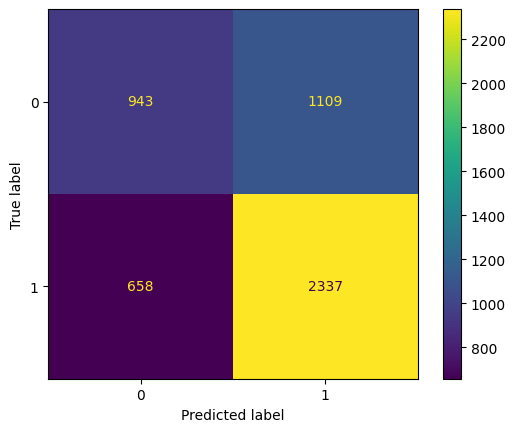

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=model.classes_)
disp.plot()
plt.show()

In [53]:
def confusion_matrix_data(model, X_test, y_test, name):
    """
    Compute the confusion matrix of the given model.
    Export a graph for the matrix. 
    Return confusion matrix array containing tn, fp, fn and tp.
    """
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=model.classes_)
    # export graph
    disp.plot()
    plt.savefig(fname='../iterations_evaluation/'+name+'_confusion_matrix')

    return cm

### FNR, FPR

In [54]:
# the confusion matrix has True Negative, False Positive, False Negative 
# and True Positive info.
tn, fp, fn, tp = cm.ravel() # the function flattens the array to a 1-Dimension array

# To get the total number of wins and losses we count the ones and zeroes, 
# respectively, from the Target variable.
wins, losses = y.value_counts()


# FPR = FP/N
fpr = fp/losses

# FNR = FN/P
fnr = fn/wins

print('False Positive Rate = '+str(fpr)+'\nFalse Negative Rate = '+str(fnr))

False Positive Rate = 0.10695341884463304
False Negative Rate = 0.044271008544708335


In [55]:
def fpr_fnr_data(cm):
    """
    Compute False Positive Rate and False Negative Rate from confusion matrix.
    """
    # the confusion matrix has True Negative, False Positive, False Negative 
    # and True Positive info.
    tn, fp, fn, tp = cm.ravel() # .ravel() flattens the array to a 1-Dimension array

    # To get the total number of wins and losses we count the ones and zeroes, 
    # respectively, from the Target variable.
    wins, losses = y.value_counts()

    fpr = fp/losses     # FPR = FP/N
    fnr = fn/wins       # FNR = FN/P

    return fpr, fnr


### ROC

C:\Users\gcmil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


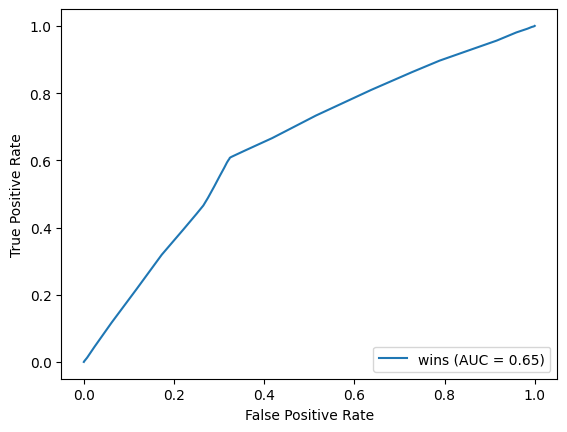

In [56]:
# ROC Graph, AUC, FPR, TPR
from sklearn.metrics import auc, roc_curve, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:, 1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='wins')
display.plot()
plt.show()


In [57]:
from sklearn.metrics import auc, roc_curve, RocCurveDisplay

def roc_data(y, pred, name):
    """
    Compute ROC information for the given model. 
    Export a graph for the curve. Return AUC value.
    """
    fpr, tpr, thresholds = roc_curve(y, pred)
    print(fpr, tpr)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='wins')
    # export graph
    display.plot()
    plt.savefig(fname='../iterations_evaluation/'+name+'_roc')

    return roc_auc

C:\Users\gcmil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.6494844737041425

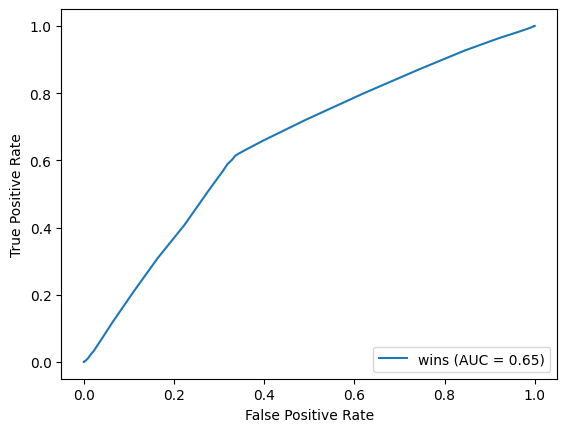

In [35]:
# example for roc_data()
roc_data(y, model.predict_proba(X)[:, 1], name='last10g_ELOk32') 

## Monitoring iteration 

A single function to compute all relevant assessment indexes and export them for future comparison.

In [76]:
import matplotlib.pyplot as plt
import json
from os import path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, auc, roc_curve, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score


def indexes(model, y, X_test, y_test, name):
    """
    Compute accuracy, FPR, FNR, confusion matrix and ROC curve.
    Exports two images, one for the confusion matrix anthe other for ROC; 
    all other indexes are added to a json file.
    """
    # Indexes computation
    accuracy = cross_val_score(model, X, y, cv = StratifiedKFold(n_splits = 10))    # accuracy
    cm = confusion_matrix_data(model, X_test, y_test, name)             # confusion matrix
    fpr, fnr = fpr_fnr_data(cm)                                         # False Positive Rate, False Negative Rate
    area_under_curve = roc_data(y, model.predict_proba(X)[:, 1], name)  # Receiver Operating Characteristic curve and Area Under the Curve
    
    # Indexes export handling
    json_filename = '../iterations_evaluation/iterations.json'

    if path.isfile(json_filename) is True:  # file exists
        # get json file
        with open(file=json_filename,mode='r') as f: # read mode
            all_indexes = json.load(f)  # json file is translated to a python dictionary
    else:   # file does not exists
        with open(file=json_filename,mode='x') as f: # create mode
            all_indexes = dict()    # create an empty dictionary
    # add new indexes to dictionary
    all_indexes.update({
        name: {
            'accuracy': [accuracy.mean(), accuracy.std()],
            'confusion_matrix': [x.item() for x in cm.ravel()], # cm is numpy.ndarray and its elements are numpy.int64; both types aren't "JSON Serialiazable" so they have to be translated to native Python types
            'FPR': fpr,
            'FNR': fnr,
            'AUC': area_under_curve
        }
    })
    # rewrite file with new indexes
    with open(file=json_filename,mode='w') as f:
        json.dump(all_indexes, f, indent=4, separators=(',',': '))
    
    return accuracy, cm, fpr, fnr, area_under_curve

    

In [77]:
accuracy, cm, fpr, fnr, auc = indexes(model, y, X_test, y_test, 'last10g_ELOk20Mvm')

## Model Selection

### Cross Validation

In [38]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

scores = cross_val_score(model, X, y, cv = StratifiedKFold(n_splits = 10))

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.63272583 0.62757528 0.67261197 0.66825208 0.64090369 0.64090369
 0.65239794 0.62980579 0.6476417  0.6262386 ]
Average CV Score:  0.6439056559211515
Number of CV Scores used in Average:  10


### Hyperparameters tuning

In [39]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [1, 10, 100, 200, 500, 1000]}
n_jobs=-1
cv=10
verbose = 4

rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, params)
clf.fit(X, y)
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']